#### Copyright and Licensing Notice

<small>Copyright 2025 H. Umapathithasan, A. Vasantharasan, N. Mehanathan, & N. Kannan
This work is licensed under the **Apache License, Version 2.0**.</small>

## Installation
**Note:** If you install dependencies using the provided `requirements.txt` file, skip the manual installation steps.

In [ ]:
#%%capture
#Get Unsloth (Code used Unsloth 2025.3.10)
%pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
%pip install tf_keras

In [ ]:
%pip install python-dotenv

## Setup

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 #Max num of input tokens (2048 tokens)
dtype = None #None = auto-detect, selects optimal PyTorch data type, used to store model weights/activations
load_in_4bit = True # (QLoRA = True) Using 4bit quantization

#Select model based on args, can also load LoRA adapters for locally saved unsloth models
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", 
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", #Specify for using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/infuse/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-08 15:27:56.608125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 15:27:56.803672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744140476.871759    1076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744140476.895568    1076 cuda_blas.cc:14

🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.10: Fast Llama patching. Transformers: 4.46.3.
   \\   /|    NVIDIA GeForce RTX 4080. Num GPUs = 1. Max memory: 15.992 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
#Parmeters for finetuning
model = FastLanguageModel.get_peft_model(
    model,
#LoRA Parameters:
    #LoRA rank of decomposition (r)
    #Takes original model W, a (m x n matrix), and breaks it down into matrix A(m x r) and matrix B(r x n) matrices
    #These smaller matrices are the LoRA adapters that are trained instead of the original weight (W), r is the parameter
    #Lower r is faster and more memory-efficient, but less accurate
    r = 32, #Use r = 8, 16, 32, 64, 128

    #Scaling Factor (lora_alpha) 
    #LoRA adapters (A and B) are added to the original weight (W) to get the fine-tuned W'
    #lora alpha scales the contribution of LoRA adapters to W', similar to learning rate in gradient descent
    #Controls how much of the learned features stored in lora adapters contribute to new fine-tuned W'
    lora_alpha = 32, #Best to use value equal to r

    lora_dropout = 0, # = 0 is optimized, applies dropout to lora adapters, prevents model from relying too much on specific learned features
    
    #y = Wx + b, where b is bias, W is weight, x is features
    bias = "none",    # = none is optimized,

    #Technique for reducing memory consumption during finetuning
    #Instead of storing all intermediate activations on the forward pass of finetuning, it only saves a subset of them
    #Computes the rest of the activations on the backward pass, (activations are the computed value that are passed into activation function)
    use_gradient_checkpointing = "unsloth", #Set True/"unsloth" for very long context, 
                                            #will use less VRAM and fit larger batch sizes, but will increase compute time
    #Set seed for reproducible random values
    random_state = 3407,
    #Rank-Stabilized LoRA
    use_rslora = False, #= True will automatically adjust lora_alpha
    #LoftQ, applies quanitzation with optimized LoRA initalization
    loftq_config = None,
    #Select modules to finetune with LoRA
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",   #These are specific projection layers within the 
                      "gate_proj", "up_proj", "down_proj",],    #transformer model's architecture
)

Unsloth 2025.3.10 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## Dataset Prep

In [3]:
from datasets import Dataset
import pandas as pd

# Paths to the CSV files
csv_path1 = "./Dataset/DatasetParams2/good_papers_with_topics_with_params.csv"  
csv_path2 = "./Dataset/DatasetParams2/bad_papers_with_topics_with_params.csv" 

# Load both CSV files into pandas DataFrames
df1 = pd.read_csv(csv_path1, keep_default_na=False)
df2 = pd.read_csv(csv_path2, keep_default_na=False)

combined_df = pd.concat([df1, df2], ignore_index=True)
if "Number of references" in combined_df.columns:
    combined_df["Number of references"] = pd.to_numeric(combined_df["Number of references"], errors="coerce")

# Convert the combined DataFrame to a Hugging Face dataset
dataset = Dataset.from_pandas(combined_df)
print(dataset)

Dataset({
    features: ['Identifier', 'Type', 'DOI', 'Title', 'Abstract', 'Number of references', 'Study Type', 'Study Population Size', 'Control Group Size', 'Sampling Method'],
    num_rows: 4227
})


In [4]:
#Transform .csv data into conversational template
def to_conversational_format(batch):

    user_prompts = [
        f"For the given Topic: {identifier}\nAsnwer if the following academic paper is good or bad\nTitle: {title}\nAbstract: {abstract}\n"
        f"Number of References: {references}\nStudy Type: {studyType}\nStudy Population Size: {popSize}"
        for title, identifier, abstract, references, studyType, popSize in zip(batch["Title"], batch["Identifier"], batch["Abstract"], batch["Number of references"], batch["Study Type"], batch["Study Population Size"])
    ]
    
    #llama response (good/bad)
    assistant_responses = batch["Type"]
    
    #Building dataset as a dictionary in HuggingFace generic format
    conversations = [
        [
            {"role": "user", "content": user_prompt},
            {"role": "assistant", "content": response} #good/bad
        ]
        for user_prompt, response in zip(user_prompts, assistant_responses)
    ]
    
    return {"conversations": conversations}

# Apply the transformation
dataset = dataset.map(to_conversational_format, batched=True,)

Map: 100%|██████████| 4227/4227 [00:00<00:00, 49535.01 examples/s]


In [5]:
#Transform conversational template into llama template
from unsloth.chat_templates import get_chat_template

#Initialize tokenizer, specify template to convert dictionary in prev. cell into 
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.1",
)

#Function to format the prompts from dict. into the llama chat template
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in convos]
    return {"text": texts}

#Format the dataset into the chat template
dataset = dataset.map(formatting_prompts_func, batched=True)

#Split dataset into 75% train and 25% test
splits = dataset.train_test_split(test_size=0.25, seed=42)

#Access the train and test sets
train_dataset_split = splits["train"]
test_dataset_split = splits["test"]

#Print the size of each split
print(f"Train dataset size: {len(train_dataset_split)}")
print(f"Test dataset size: {len(test_dataset_split)}")

#Print sample of dataset in llama chat template
print(train_dataset_split[2]["text"])

Map: 100%|██████████| 4227/4227 [00:00<00:00, 31738.74 examples/s]

Train dataset size: 3170
Test dataset size: 1057
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

For the given Topic: Ethnicity and clinical outcomes in COVID-19
Asnwer if the following academic paper is good or bad
Title: Racial and Ethnic Disparities in Population-Level Covid-19 Mortality.
Abstract: No abstract found
Number of References: 6.0
Study Type:  cross-sectional
Study Population Size:  not specified<|eot_id|><|start_header_id|>assistant<|end_header_id|>

bad<|eot_id|>


## Model Training

In [ ]:
from trl import SFTTrainer #Supervised Fine-tuning Trainer from HuggingFace
from transformers import TrainingArguments, DataCollatorForSeq2Seq #HF
from unsloth import is_bfloat16_supported

#Specify Trainer Params (Docs: https://huggingface.co/docs/trl/en/sft_trainer)
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset_split,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer), #Batches and preprocesses data
    dataset_num_proc = 2, #Num of processes for processing dataset
    packing = False, #Packs multiple sequences within max_seq_length (Packs multiple prompts/responses together)
    #(Docs: https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)
    args = TrainingArguments(
        per_device_train_batch_size = 2, #batch size, bigger batch will create smoother training loss curve
        gradient_accumulation_steps = 4, 
        warmup_steps = 5,   #Num of training steps used to slowly increase learning rate from 0 to learning_rate
        num_train_epochs = 3, #Num of runs through full dataset (epochs).
        # max_steps = 250, #Num of times weights are updated,Total samples visited = batch size * gradient accumulation steps * max steps
        learning_rate = 2e-4, #try = 2e-4, 1e-4, 5e-5, 2e-5
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10, #(logging_steps = 1, log training metrics after every 1 step/weight update)
        optim = "adamw_8bit", #optimizer, carries out gradient descent and adjusts learning rate
        weight_decay = 0.01, #Decreases weight during each optimizer step
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", #Use this for WandB etc
    ),
)

/mnt/c/Projects/VSCodeWorkspace/StudyScreeningLanguageModel/unsloth_compiled_cache/UnslothSFTTrainer.py:587: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/mnt/c/Projects/VSCodeWorkspace/StudyScreeningLanguageModel/unsloth_compiled_cache/UnslothSFTTrainer.py:601: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/mnt/c/Projects/VSCodeWorkspace/StudyScreeningLanguageModel/unsloth_compiled_cache/UnslothSFTTrainer.py:615: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Map (num_proc=2): 100%|██████████| 3170/3170 [00:02<00:00, 1239.07 examples/s]


In [7]:
#Using Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=20): 100%|██████████| 3170/3170 [00:00<00:00, 6358.58 examples/s]


In [8]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4080. Max memory = 15.992 GB.
2.66 GB of memory reserved.


In [9]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,170 | Num Epochs = 3 | Total steps = 1,188
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 48,627,712/1,889,840,128 (2.57% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,5.243100
20,0.443600
30,0.436500
40,0.320500
50,0.300500
60,0.338800
70,0.261000
80,0.199700
90,0.190300
100,0.139200


In [10]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")
print(f"All Metrics: {trainer_stats.metrics}")

1810.6626 seconds used for training.
30.18 minutes used for training.
Peak reserved memory = 3.662 GB.
Peak reserved memory for training = 1.002 GB.
Peak reserved memory % of max memory = 22.899 %.
Peak reserved memory for training % of max memory = 6.266 %.
All Metrics: {'train_runtime': 1810.6626, 'train_samples_per_second': 5.252, 'train_steps_per_second': 0.656, 'total_flos': 9.10593802812334e+16, 'train_loss': 0.15609180873341433, 'epoch': 2.998107255520505}


## Test Inference

### Manual Test

In [11]:
print("Size of test dataset: ", len(test_dataset_split))
# i = 20 #bad sample
i = 474 #good sample
#print(test_dataset_split[i]["conversations"])
conversation = test_dataset_split[i]["conversations"]

# Extract the "user" message
user_message = next(
    (message["content"] for message in conversation if message["role"] == "user"), 
    None
)

# Extract the "assistant" response
assistant_response = next(
    (message["content"] for message in conversation if message["role"] == "assistant"), 
    None
)

print("User Message:", user_message)
print("Expected Assistant Response:", assistant_response)

Size of test dataset:  1057
User Message: For the given Topic: The effect of comorbid pulmonary diseases on the severity of COVID-19 patients
Asnwer if the following academic paper is good or bad
Title: Association of chronic anticoagulant and antiplatelet use on disease severity in SARS-COV-2 infected patients.
Abstract: No abstract found
Number of References: 12.0
Study Type:  retrospective cohort study
Study Population Size:  28076
Expected Assistant Response: bad


In [12]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": user_message},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nFor the given Topic: The effect of comorbid pulmonary diseases on the severity of COVID-19 patients\nAsnwer if the following academic paper is good or bad\nTitle: Association of chronic anticoagulant and antiplatelet use on disease severity in SARS-COV-2 infected patients.\nAbstract: No abstract found\nNumber of References: 12.0\nStudy Type:  retrospective cohort study\nStudy Population Size:  28076<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nbad<|eot_id|>']

### Test Full Dataset

In [17]:
from unsloth.chat_templates import get_chat_template
import random 

print("Size of test dataset: ", len(test_dataset_split))
# Size is 2499
# correct_ans = 0
tries = len(test_dataset_split)
i = 0

# Categorize results as TP, FP, TN, FN
tp, fp, tn, fn = 0, 0, 0, 0

for index in range(tries):
  #print(test_dataset_split[i]["conversations"])
  # i = random.randint(0,2498)
  conversation = test_dataset_split[i]["conversations"]

  # Extract the user message
  user_message = next(
      (message["content"] for message in conversation if message["role"] == "user"), 
      None
  )

  # Extract expected assistant response
  assistant_response = next(
      (message["content"] for message in conversation if message["role"] == "assistant"), 
      None
  )
  i+=1

  #   print("User Message:", user_message)
  #   print("Expected Assistant Response:", assistant_response)

  tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
  )
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference

  messages = [
      {"role": "user", "content": user_message},
  ]
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize = True,
      add_generation_prompt = True, # Must add for generation
      return_tensors = "pt",
  ).to("cuda")

  outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                          temperature = 1.0, min_p = 0.1)   #Test temp=1.0, temp=1.5
  model_response = str(tokenizer.batch_decode(outputs))
  ans = model_response.split("<|start_header_id|>assistant<|end_header_id|>")[1].split("<|eot_id|>")[0].strip()
  
  
  if "good" in assistant_response:

    if "good" in ans:
      tp += 1
    elif "bad" in ans:
      fn += 1
    else:
      print(f"Unexpected prediction '{ans}' from index {i}")
  elif "bad" in assistant_response:

    if "bad" in ans:
      tn += 1
    elif "good" in ans:
      fp += 1
    else:
      print(f"Unexpected prediction '{ans}' from index {i}")
  else:
    print(f"Unexpected target prediction '{assistant_response}' from index {i}")



Size of test dataset:  1057
Unexpected prediction '\n\n einer frühen und einer späten Phase unterschieden werden können, die eine Therapie unter Differenzierung bedürfen.Ein intensiver Sauerstoffbedarf und eine Abgabe von infektiösen Partikeln sollten die therapeutische Intervallösung der ARI verhind']' from index 489


In [18]:
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# Calculate metrics
accuracy = (tp + tn)/(tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)

print("Number of correct answers: ", tp + tn)
print("Number of wrong answers: ", fp + fn)
print("# of tests: ", tries)

print(f"\nAccuracy = {accuracy}\nRecall = {recall}\nPrecision = {precision}")

TP=194, FP=54, TN=770, FN=38
Number of correct answers:  964
Number of wrong answers:  92
# of tests:  1057

Accuracy = 0.9128787878787878
Recall = 0.8362068965517241
Precision = 0.782258064516129


/tmp/ipykernel_1076/1584894471.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Bad', 'Good'])
/tmp/ipykernel_1076/1584894471.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Bad', 'Good'])


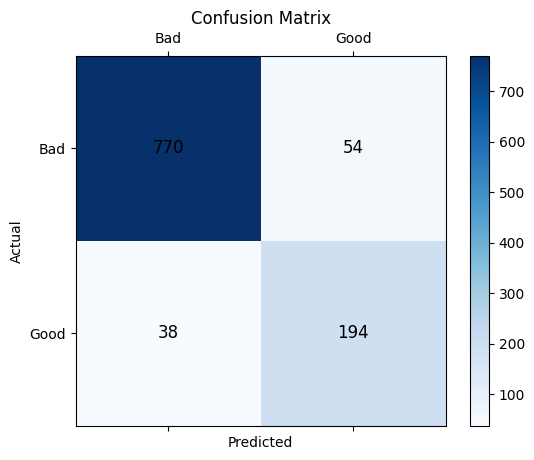

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Construct the confusion matrix
confusion_matrix = np.array([[tn, fp],
                             [fn, tp]])

#Plotting
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)

#Add labels
ax.set_xticklabels([''] + ['Bad', 'Good'])
ax.set_yticklabels([''] + ['Bad', 'Good'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

#Annotate each cell with its value
for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=12)

plt.title("Confusion Matrix")
plt.show()

## Save Model

In [27]:
model.save_pretrained("llama3.2_3B_fullParamDataset_3epoch") # Local saving
tokenizer.save_pretrained("llama3.2_3B_fullParamDataset_3epoch")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('llama3.2_3B_fullParamDataset_3epoch/tokenizer_config.json',
 'llama3.2_3B_fullParamDataset_3epoch/special_tokens_map.json',
 'llama3.2_3B_fullParamDataset_3epoch/tokenizer.json')

In [ ]:
import os

# API Key Handle
try:
  from dotenv import load_dotenv
  
  load_dotenv('key.env')
  key = os.getenv('HUGGINGFACE_API_KEY')
except ImportError:
    print("python-dotenv not installed")
    key = None
except OSError:
    print("key.env file not found")
    key = None

if key is None:
    print("No API key found\nIf you are pushing to a repo set it in key.env file.")

# Merge to 16bit
# if True: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if True: model.push_to_hub_merged("username/model_name", tokenizer, save_method = "merged_16bit", token = key)

# # Merge to 4bit
# Find our model on HuggingFace at 1nfuse/llama3.2-3B_SLR_FTmodel-4bit-3epoch
# if True: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit_forced",)
# if True: model.push_to_hub_merged("username/model_name", tokenizer, save_method = "merged_4bit_forced", token = key)

# # Save to q4_k_m GGUF
# Find our model on HuggingFace at 1nfuse/llama3.2-3B_SLR_FTmodel-q4km-3epoch
# if True: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
# if True: model.push_to_hub_gguf("username/model_name", tokenizer, quantization_method = "q4_k_m", token = key)

Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...
Done.
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 10 minutes for Llama-7b... Done.
Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...
Done.
Unsloth: Saving 4bit Bitsandbytes model. Please wait...


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


Saved merged_4bit model to https://huggingface.co/1nfuse/llama3.2-3B_SLR_FTmodel-4bit-3epoch
